In [1]:
import osmnx as ox
import geopandas as gpd
import pandas as pd
import os

In [2]:
# Load and project data
gdf = gpd.read_file(os.path.join('..', 'datos', '00_insumos', 'ubicacion_cditvallejo.gpkg'))
gdf = gdf.to_crs(epsg=32614)
gdf.head(1)

,nombre,geometry
0,Centro de Desarrollo e Innovación Vallejo-i,POINT (480915.239 2154853.577)


In [3]:
buffer = gdf.copy()
buffer['geometry'] = buffer.geometry.buffer(7500)
bb = buffer.to_crs(4326).total_bounds.tolist()
bb

[-99.25333419050017, 19.420387923657948, -99.110394998496, 19.555945301523263]

In [4]:
# Descargamos la red de calles dentro del bounding box
G = ox.graph.graph_from_bbox(
    bb,
    network_type='all',
    simplify=False
)
print(f"{len(G.nodes)} nodos y {len(G.edges)} aristas descargados")

147284 nodos y 284247 aristas descargados


In [5]:
# Projectamos la red a la misma proyección que el punto de interés
G = ox.project_graph(G, to_crs=gdf.crs)
# Buscamos el nodo más cercano al punto de interés
nodos_cercanos = ox.distance.nearest_nodes(
    G, 
    gdf.geometry.x, 
    gdf.geometry.y
    )
print(f"Nodo más cercano: {nodos_cercanos[0]}")

Nodo más cercano: 12124290713


In [6]:

import networkx as nx
from shapely.geometry import MultiPoint, Point

distancias = [500, 1500, 5000]
nodo_origen = nodos_cercanos[0]

# Convertimos a grafo no dirigido para calcular distancias en ambas direcciones
G_undir = G.to_undirected()

isodistancias = []
for dist in distancias:
    # Nodos alcanzables desde el origen dentro de la distancia por red vial
    longitudes = nx.single_source_dijkstra_path_length(
        G_undir, nodo_origen, cutoff=dist, weight='length'
    )
    # Coordenadas de los nodos alcanzables
    puntos = [Point(G.nodes[n]['x'], G.nodes[n]['y']) for n in longitudes.keys()]
    # Polígono convex hull que cubre todos los nodos alcanzables
    poligono = MultiPoint(puntos).convex_hull
    isodistancias.append({'distancia_m': dist, 'geometry': poligono})

gdf_iso = gpd.GeoDataFrame(isodistancias, crs=gdf.crs)
gdf_iso


,distancia_m,geometry
0,500,"POLYGON ((480819.832 2154398.517, 480808.28 21..."
1,1500,"POLYGON ((480783.57 2153468.164, 480589.854 21..."
2,5000,"POLYGON ((480844.639 2150273.753, 479922.369 2..."


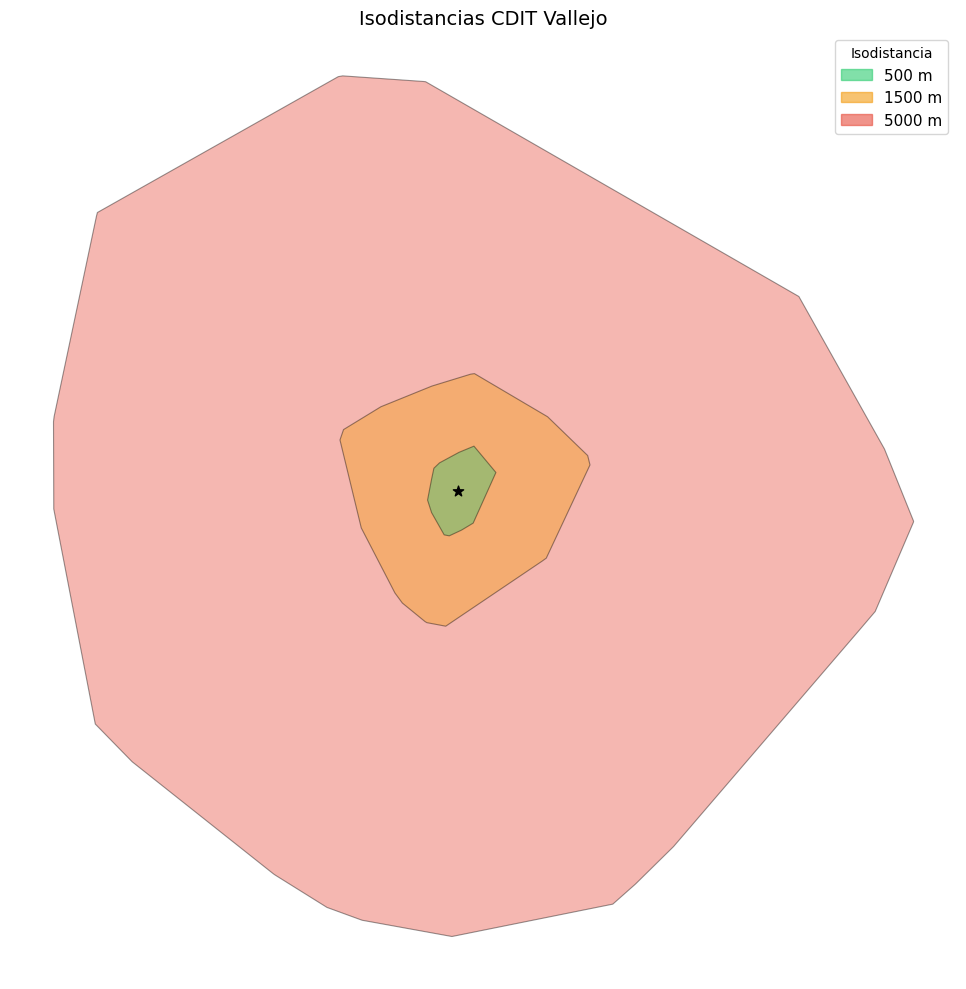

In [7]:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

colores = {500: '#2ecc71', 1500: '#f39c12', 5000: '#e74c3c'}

fig, ax = plt.subplots(figsize=(10, 10))

# Capas de isodistancia de mayor a menor (para que la más pequeña quede encima)
for _, row in gdf_iso.sort_values('distancia_m', ascending=False).iterrows():
    gdf_iso[gdf_iso['distancia_m'] == row['distancia_m']].plot(
        ax=ax,
        color=colores[row['distancia_m']],
        alpha=0.4,
        edgecolor='black',
        linewidth=0.8
    )

# Punto de origen
gdf.plot(ax=ax, color='black', markersize=60, zorder=5, marker='*')

# Leyenda
parches = [
    mpatches.Patch(color=colores[d], alpha=0.6, label=f'{d} m')
    for d in distancias
]
ax.legend(handles=parches, title='Isodistancia', fontsize=11)
ax.set_title('Isodistancias CDIT Vallejo', fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()


In [8]:
gdf_iso.to_file(os.path.join('..', 'datos', '01_procesos', 'isodistancias_cditvallejo.geojson'))